## Embedding viz

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-10-16 22:30:38.327660: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 22:30:39.295149: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 22:30:39.602770: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 22:30:39.604107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instruc

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run)
importlib.reload(models.train_val)
importlib.reload(data.data_utils)


<module 'data.data_utils' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/data/data_utils.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 2.2%
RAM Usage: 3.3%
Available RAM: 1.4T
Total RAM: 1.5T
52.4G


In [5]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA H100 80GB HBM3 - Memory Allocated: 0.00 GB


### Setup

In [6]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric
from data.data_utils import RegionPairDataset
from torch.utils.data import Subset

from data.data_viz import plot_umap_embeddings_w_fc

Loading data...
Number of components for 95% variance PCA: 27


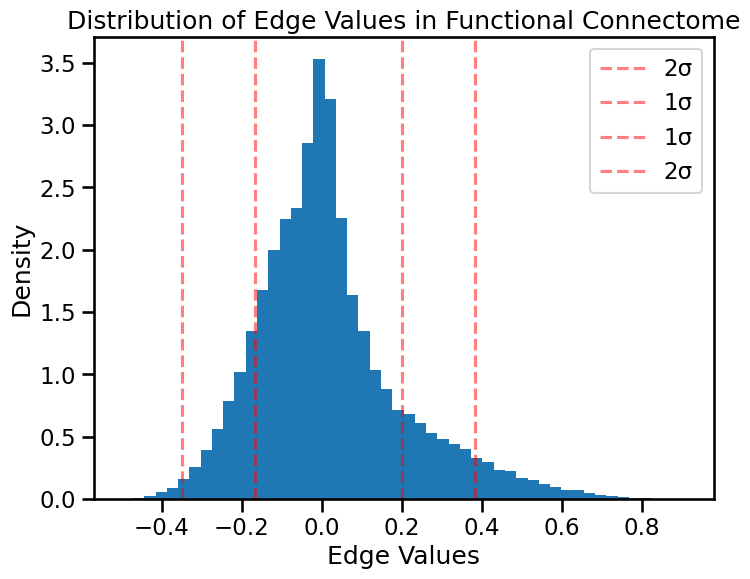

In [9]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_umap_embeddings_w_fc

### SMT POOL EMBEDDINGS ###
from models.smt import SharedSelfAttentionPoolingModel, SharedSelfAttentionCLSPoolingModel

# Load data
print("Loading data...")
X = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')

### PCA ###
X_pca = load_transcriptome(parcellation='S456', run_PCA='95var', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')
Y = load_connectome(parcellation='S456', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Subset all data using valid indices
X_valid = X[valid_indices]
X_pca = X_pca[valid_indices]
Y_valid = Y[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]

# Plot histogram of edge values
plt.figure(figsize=(8, 6))
plt.hist(Y.flatten(), bins=50, density=True)

# Add std dev markers
mean = np.mean(Y)
std = np.std(Y)
for i in [-2, -1, 1, 2]:
    plt.axvline(mean + i*std, color='r', linestyle='--', alpha=0.5, 
                label=f'{i}σ' if i > 0 else f'{abs(i)}σ')

plt.xlabel('Edge Values')
plt.ylabel('Density')
plt.title('Distribution of Edge Values in Functional Connectome')
plt.legend()
plt.show()

### Brain montage

In [10]:
import os
os.environ["NILEARN_DATA"] = "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/nilearn_data"


In [11]:
import numpy as np
from brainmontage import create_montage_figure, save_image
from matplotlib import pyplot as plt

In [12]:

# 3. Define ROI values (simple example here)
roivals = np.arange(86) + 1  # assumes fs86 has 86 regions
import os
from brainmontage import brainmontage
from nilearn import datasets as nldatasets
from nilearn import datasets as nldatasets


In [13]:

# Patch just the fetch_surf_fsaverage call to set data_dir properly
_original_fetch_surf = nldatasets.fetch_surf_fsaverage

def _patched_fetch_surf_fsaverage(*args, **kwargs):
    kwargs['data_dir'] = "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/nilearn_data"
    return _original_fetch_surf(*args, **kwargs)

nldatasets.fetch_surf_fsaverage = _patched_fetch_surf_fsaverage

Text(0.5, 1.0, 'fs86 Montage Preview')

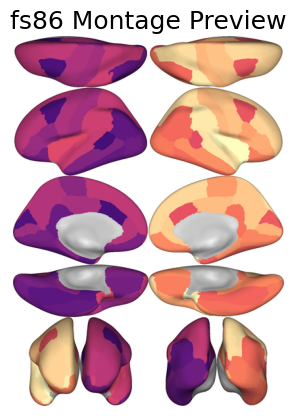

In [ ]:
# 4. Create a basic montage image
img = create_montage_figure(
    roivals,
    atlasname='fs86',
    viewnames='all',
    surftype='infl',
    clim=[0, 86],
    colormap='magma'
)


plt.figure()
plt.imshow(img)
plt.axis('off')
plt.title("fs86 Montage Preview")

In [8]:
cortical_network_labels = network_labels[:400]
print(cortical_network_labels)

['Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis'
 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis'
 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'SomMot' 'SomMot' 'SomMot'
 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot'
 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot'
 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot'
 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot'
 'SomMot' 'SomMot' 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn'
 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn'
 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn'
 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn'
 'SalVentAttn' 'SalVentAttn' 'SalVentAttn' 'SalVentAttn' 'SalVentAttn'
 'SalVentAttn' 'SalVentAttn' 'SalVentAttn' 'SalVentAttn' 'SalVentAttn'
 'SalVentAttn' 'SalVentAttn' 'SalVentAttn' 'SalVentAttn' 'SalVentAttn'
 'Sa

In [94]:
cortical_network_labels

array(['Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis',
       'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis',
       'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis',
       'Vis', 'Vis', 'Vis', 'Vis', 'SomMot', 'SomMot', 'SomMot', 'SomMot',
       'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot',
       'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot',
       'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot',
       'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot',
       'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot',
       'SomMot', 'SomMot', 'SomMot', 'DorsAttn', 'DorsAttn', 'DorsAttn',
       'DorsAttn', 'DorsAttn', 'DorsAttn', 'DorsAttn', 'DorsAttn',
       'DorsAttn', 'DorsAttn', 'DorsAttn', 'DorsAttn', 'DorsAttn',
       'DorsAttn', 'DorsAttn', 'DorsAttn', 'DorsAttn', 'DorsAttn',
       'DorsAttn', 'DorsAttn', 'DorsAttn', 'DorsAttn', 'DorsAttn',
       'SalVentAttn', 'SalVentAttn', 'S

In [15]:
# Per subnetwork SMT > Bilinear gains
mean_gains = {
    'Vis': 0.088,
    'SomMot': 0.081, 
    'DorsAttn': 0.063,
    'SalVentAttn': 0.061,
    'Limbic': 0.044,
    'Cont': 0.054,
    'Default': 0.047,
    'Subcortical': 0.036,
    'Cerebellum': 0.058
}

intra_network_gains = {
    'Vis': 0.11,
    'SomMot': 0.11,
    'DorsAttn': 0.071,
    'SalVentAttn': 0.069,
    'Limbic': 0.035,
    'Cont': 0.057,
    'Default': 0.040,
    'Subcortical': 0.032,
    'Cerebellum': 0.035
}

inter_network_gains = {
    'Vis': 0.069,
    'SomMot': 0.056,
    'DorsAttn': 0.055,
    'SalVentAttn': 0.054,
    'Limbic': 0.054,
    'Cont': 0.051,
    'Default': 0.055,
    'Subcortical': 0.041,
    'Cerebellum': 0.082
}

network_colors = {
        'Frontoparietal (FPN)': '#D68E63',  # Darker Orange
        'Default mode (DMN)': '#D67A7A',     # Darker Red
        'Salience (SN)': '#55B755',          # Darker Green
        'Limbic (LN)': '#D6CC7A',            # Darker Yellow
        'Dorsal attention (DAN)': '#D67AD6',  # Darker Magenta
        'Somatosensory motor (SMN)': '#639CD6', # Darker Light Blue
        'Visual (VN)': '#7B3B7B'             # Darker Purple
    }

cortical_network_labels = network_labels[:400]
print(cortical_network_labels)

['Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis'
 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis'
 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'Vis' 'SomMot' 'SomMot' 'SomMot'
 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot'
 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot'
 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot'
 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot' 'SomMot'
 'SomMot' 'SomMot' 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn'
 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn'
 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn'
 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn' 'DorsAttn'
 'SalVentAttn' 'SalVentAttn' 'SalVentAttn' 'SalVentAttn' 'SalVentAttn'
 'SalVentAttn' 'SalVentAttn' 'SalVentAttn' 'SalVentAttn' 'SalVentAttn'
 'SalVentAttn' 'SalVentAttn' 'SalVentAttn' 'SalVentAttn' 'SalVentAttn'
 'Sa

In [16]:
import matplotlib.colors as mcolors
import numpy as np

# Map network label to RGB color
network_to_color = {
    'Vis': '#7B3B7B',
    'SomMot': '#639CD6',
    'DorsAttn': '#D67AD6',
    'SalVentAttn': '#55B755',
    'Limbic': '#D6CC7A',
    'Cont': '#D68E63',
    'Default': '#D67A7A'
}

# Convert labels to RGB triplets for each ROI
roi_vals = np.array([
    mcolors.to_rgb(network_to_color.get(label, "#BBBBBB"))  # fallback to gray
    for label in cortical_network_labels
])  # shape (400, 3)

For cmapfile=lut, override input values and clim to display LUT colormap: /ext3/miniconda3/lib/python3.11/site-packages/brainmontage/atlases/schaefer400_7Networks_LUT.txt.


  warn(

  warn(



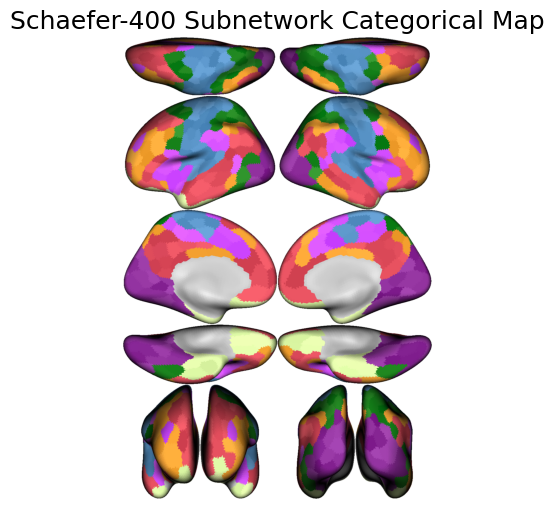

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from brainmontage import create_montage_figure

# === Step 1: Define the network color mapping === #
network_to_color = {
    'Vis': '#7B3B7B',
    'SomMot': '#639CD6',
    'DorsAttn': '#D67AD6',
    'SalVentAttn': '#55B755',
    'Limbic': '#D6CC7A',
    'Cont': '#D68E63',
    'Default': '#D67A7A'
}

# === Step 2: Map cortical network labels to RGB values === #
roi_vals = np.array([
    mcolors.to_rgb(network_to_color.get(label, "#BBBBBB"))  # default gray if missing
    for label in cortical_network_labels
])  # shape (400, 3)

# === Step 3: Create the montage figure === #
img = create_montage_figure(
    roivals=roi_vals,
    atlasname='schaefer400',
    viewnames='all',
    surftype='infl',
    colormap='lut',
    no_lookup=True,
    backgroundcolor='white',
    upscale_factor=2,
    face_mode='best'
)

# === Step 4: Show it inline === #
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Schaefer-400 Subnetwork Categorical Map")
plt.show()